# RAMP: Predicting volcanic events from Tephrochronology of the Southern and Austral Volcanic Zones of the Andes
*Consuelo Martinez, Chiara Marmo, Guillaume Delpech (GEOPS, UPS), Marine Le Morvan, Thomas Moreau (Inria), François Caud (DATAIA, UPS)*

## Table of contents

* [1. Exploratory Data Analysis](#exploration)
  * [1.1 Loading data](#11-loading-data-↑)
  * [1.2 Data analysis](#22-data-analysis-↑)
* [2. Baseline model](#baseline)
* [3. Modelling](#modelling)

In [1]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from scipy import stats
from optuna import Trial, samplers
from pandas import DataFrame, Series
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    RobustScaler, StandardScaler,
)
from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.svm import SVC
from sklearn.metrics import (
    balanced_accuracy_score,
    classification_report,
    confusion_matrix, 
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import (
    cross_val_score, 
    GridSearchCV, 
    StratifiedGroupKFold,
)
from sklearn.experimental import enable_hist_gradient_boosting
from xgboost import XGBClassifier

c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


**Thoughts**
- [ ] Handle missing value
- [ ] The cross-validator should keep all the instance of a given 

## 1 Exploratory Data Analysis <a class="anchor" id="exploration"></a> [↑](#Table-of-contents)

### 1.1 Loading data <a class="anchor" id="loading_data"></a> [↑](#Table-of-contents)

In [2]:
# Load train and test data (working only on train data).
train_df, test_df = pd.read_csv('../data/train.csv'), pd.read_csv('../data/test.csv')
assert (train_df.columns == test_df.columns).all()
print(f"Shapes. Train: {train_df.shape}, Test: {test_df.shape}")

Shapes. Train: (6220, 95), Test: (839, 95)


In [3]:
# Retrieve the geochemical data. FeO, Fe2O3 and FeO2O3T are dropped because
# FeOT is a different expression of the same element (Fe).
# P2O5 and Cl are also dropped because they are sporadically analyzed.
majors = ['SiO2_normalized', 'TiO2_normalized', 'Al2O3_normalized',
          'FeOT_normalized',
          # 'FeO_normalized', 'Fe2O3_normalized', 'Fe2O3T_normalized',
          'MnO_normalized', 'MgO_normalized', 'CaO_normalized',
          'Na2O_normalized', 'K2O_normalized',
          # 'P2O5_normalized','Cl_normalized'
          ]
traces = ['Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Cs', 'Ba', 'La',
          'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy',
          'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'Pb',
          'Th', 'U']

In [4]:
# Keep only geochemical data.
X_majors_train = train_df.loc[:, majors]
X_traces_train = train_df.loc[:, traces]
X_train_df = pd.concat([X_majors_train, X_traces_train], axis=1)

X_majors_test = test_df.loc[:, majors]
X_traces_test = test_df.loc[:, traces]
X_test_df = pd.concat([X_majors_test, X_traces_test], axis=1)

# The model will take numpy arrays as input.
X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

Labels for the train and test sets.
We use a dictionary to store the correspondence between categories and integer labels for this dataset.

In [5]:
# Hard code int_to_cat dict and retrieve cat_to_int with dictionary 
# comprehension to use in all needed files.
int_to_cat = {
    0: "1852 Llaima",
    1: "Achen",
    2: "Arauco",
    3: "Cha1",
    4: "Enco",
    5: "Grande",
    6: "H1",
    7: "HW3",
    8: "HW6",
    9: "Hua-hum",
    10: "Huilo",
    11: "La Junta",
    12: "Lepué",
    13: "Llaima Pumice",
    14: "MB1",
    15: "MC12",
    16: "Mil Hojas",
    17: "Neltume",
    18: "PCC2",
    19: "PCC2011",
    20: "Pirehueico",
    21: "Playas Blanca-Negra",
    22: "Pucón",
    23: "Puesco",
    24: "Quet1",
    25: "R1",
    26: "Ranco",
    27: "Riñihue",
    28: "Vcha-2008",
    29: "Vilcún",
}

cat_to_int = {v: k for k, v in int_to_cat.items()}

In [6]:
y_train = np.array(train_df['Event'].map(cat_to_int).fillna(-1).astype('int8'))
print("y_train:", y_train.shape, y_train)

y_test = np.array(test_df['Event'].map(cat_to_int).fillna(-1).astype('int8'))
print("y_test:", y_test.shape, y_test[:50])

y_train: (6220,) [19 19 19 ... 28 28  8]
y_test: (839,) [19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  5  5  5  5  5  5  5  5
  5  5]


### 2.2 Data Analysis <a class="anchor" id="data-analysis"></a> [↑](#Table-of-contents)

In [7]:
tephras_df = train_df[majors+traces+['Event', 'SampleID']]
print(tephras_df.shape)
tephras_df.info()

(6220, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6220 entries, 0 to 6219
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SiO2_normalized   5095 non-null   float64
 1   TiO2_normalized   5095 non-null   float64
 2   Al2O3_normalized  5095 non-null   float64
 3   FeOT_normalized   5095 non-null   float64
 4   MnO_normalized    4931 non-null   float64
 5   MgO_normalized    5095 non-null   float64
 6   CaO_normalized    5095 non-null   float64
 7   Na2O_normalized   5095 non-null   float64
 8   K2O_normalized    5095 non-null   float64
 9   Rb                1307 non-null   float64
 10  Sr                1380 non-null   float64
 11  Y                 1308 non-null   float64
 12  Zr                1383 non-null   float64
 13  Nb                1295 non-null   float64
 14  Cs                1266 non-null   float64
 15  Ba                1293 non-null   float64
 16  La                1289 non-null

There is only numerical features (used for prediction).

#### Missing values

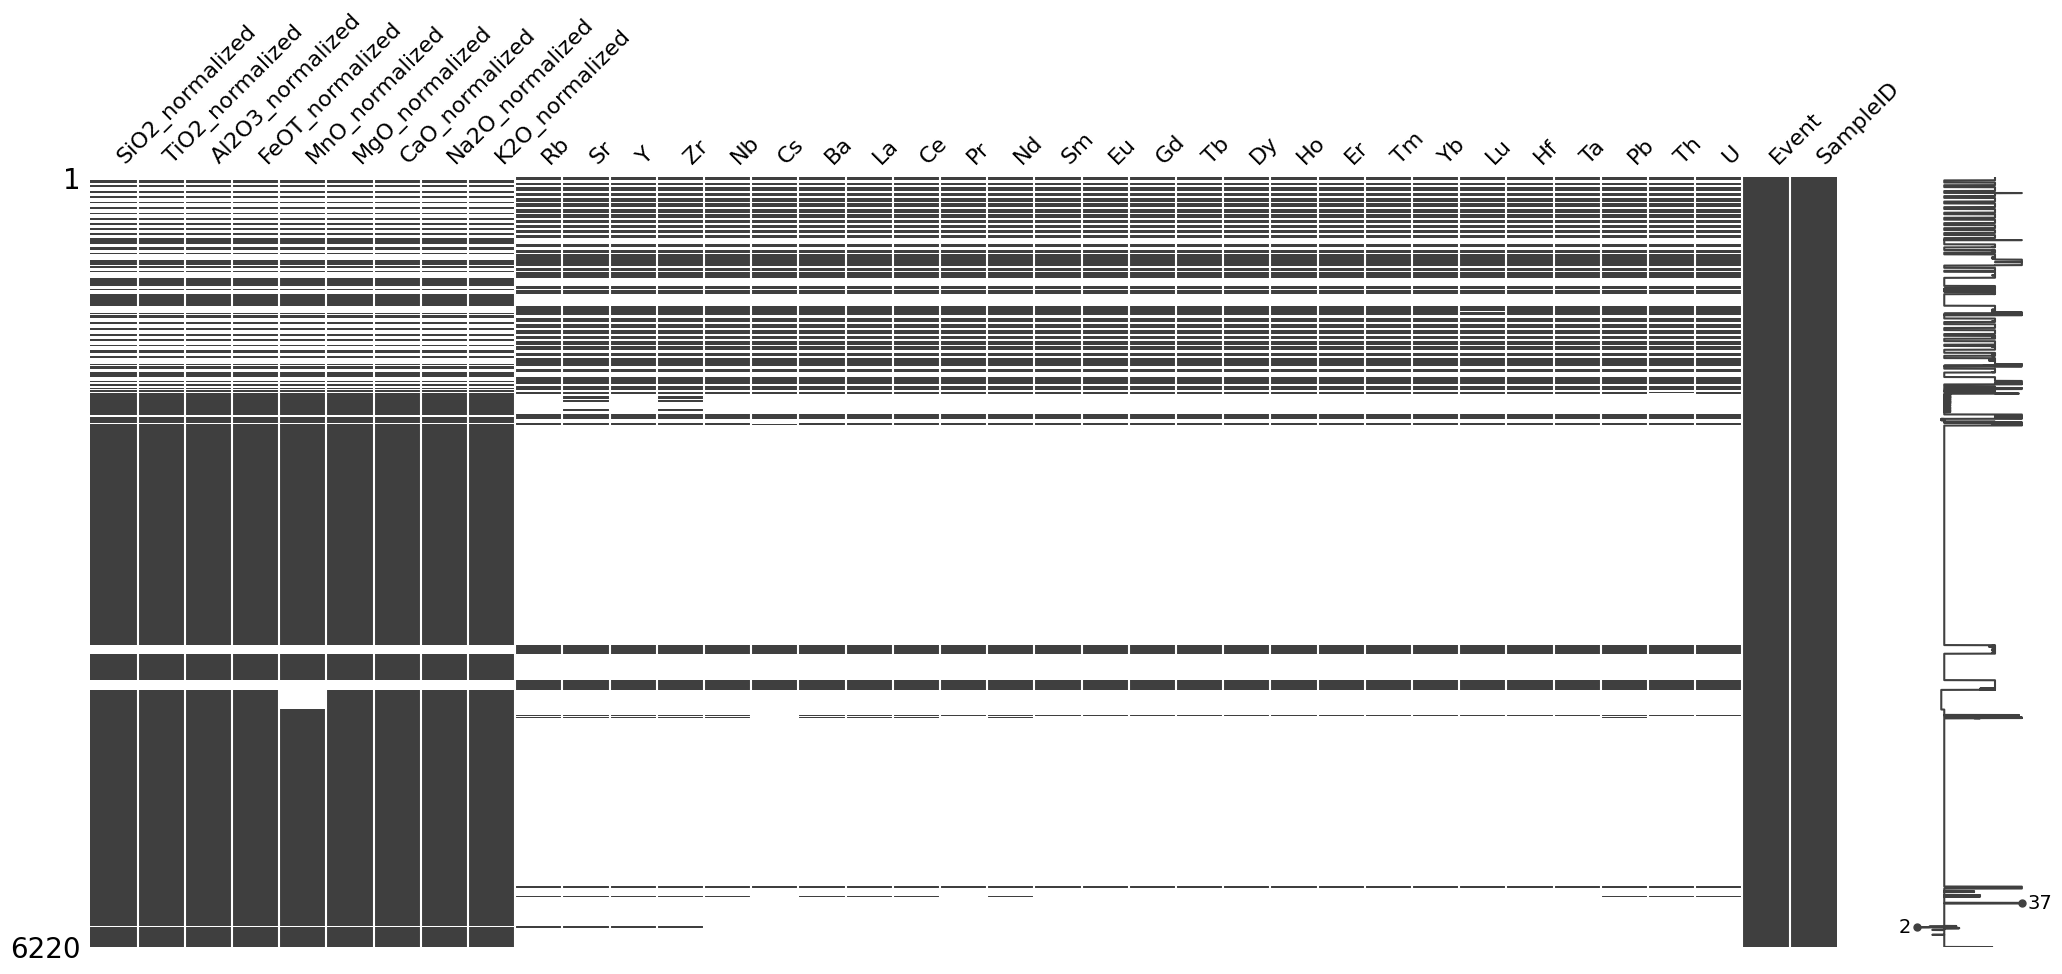

In [8]:
# Missing values
msno.matrix(tephras_df);

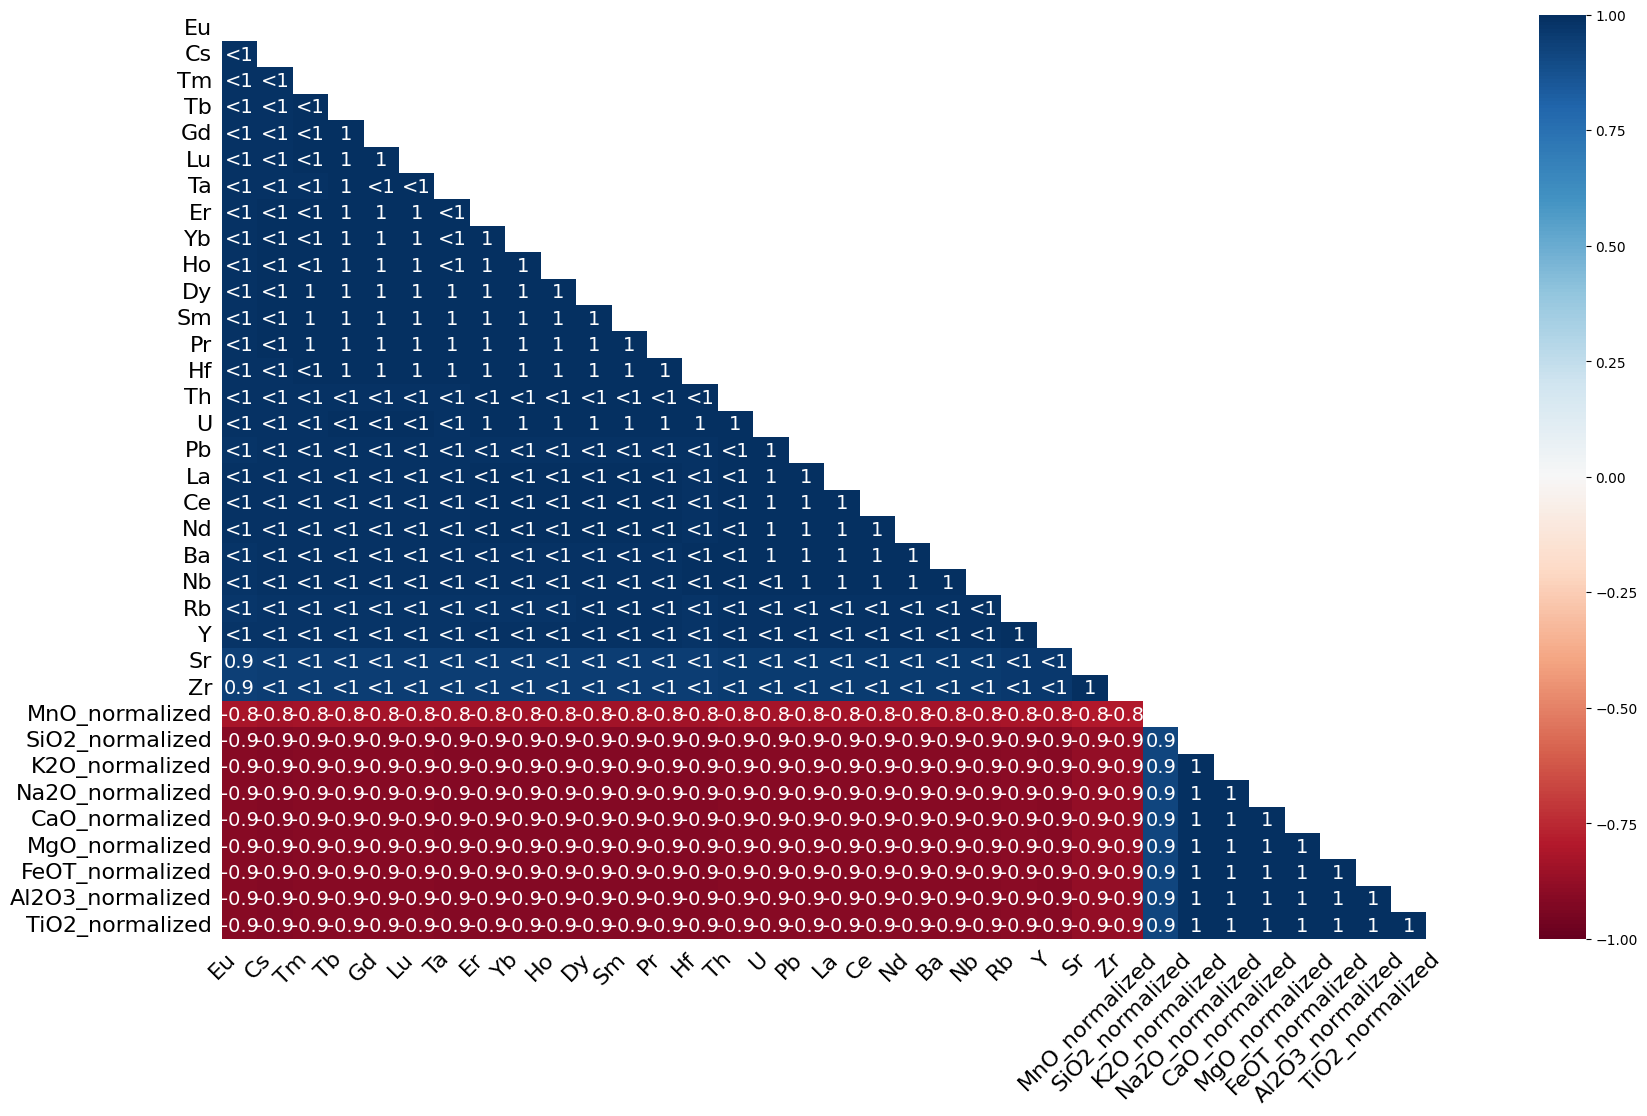

In [9]:
ax = msno.heatmap(tephras_df, filter="bottom", sort="ascending")

**Missing Values**

> * Some observations have missing value only for normalized columns (let be MissingType I) while other have missing value only for non-normalized columns (MissingType II), while other have value for almost all variables (MissingType 0).
> * We will create a new feature to encode if one observation is MissingType I or MissingType II. 
>   * compute1: number of missing values in normalized columns divided by number of missing in non normalized columns (keep the full information)
>       * Then possibly recode if fewer classes since the more important information we want to capture is just being of type MissingType I or MissingType II. (use `FunctionTransformer` to create this column in a pipeline).
> 
> * **How to handle missingness?**
>   * Imputation + keep track of missingness
>       * simple (median)
>       * simple (median) + add_indicator (MissingIndicator) + drop redundant missingness column (corresponding to columns with identical missingness profile)
>       * knn imputer
>       * iterative imputer
>   * Use robust predictor

In [10]:
# For each row,
# Count the number of missings for columns ending with '_normalized' ("MNSO_MAJORS")
# Count the number of missings for other columns ("MNSO_TRACES")
# Divide the "MSNO_MAJORS" BY "MSNO_TRACES"
majors_col_idx = np.nonzero(X_train_df.columns.str.contains("normalized"))[0]
traces_col_idx = np.nonzero(~X_train_df.columns.str.contains("normalized"))[0]

def missings_type_col(x: pd.DataFrame):
    x_ = x.copy()
    
    if isinstance(x_, np.ndarray):
        x_ = pd.DataFrame(x_)
    msno_majors = x_.iloc[:, majors_col_idx].isna().sum(axis=1)
    msno_traces = x_.iloc[:, traces_col_idx].isna().sum(axis=1)

    return msno_majors > msno_traces

print(majors_col_idx, traces_col_idx)
missings_type_col(X_train_df)

[0 1 2 3 4 5 6 7 8] [ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34]


0        True
1        True
2        True
3        True
4        True
        ...  
6215    False
6216    False
6217    False
6218    False
6219     True
Length: 6220, dtype: bool

### Conditional distributions and correlation analysis

In [11]:
# sns.pairplot(tephras_df[majors+["Event"]], hue="Event")

* Some feature seemed to be highly correlated.

In [12]:
corr_matrix = X_train_df.corr().unstack().sort_values(ascending=False)
corr_matrix = pd.DataFrame(corr_matrix).reset_index()
corr_matrix.columns = ["col1", "col2", "correlation"]
# Filter the correlation matrix based on the condition
filtered_corr_matrix = corr_matrix[(corr_matrix["correlation"] > 0.85) & (corr_matrix["correlation"] < 1)]
# Keep every other line (delete one line over two)
filtered_corr_matrix = filtered_corr_matrix[::2]
# Display the result
print(filtered_corr_matrix)


    col1 col2  correlation
35    Yb    Y     0.976570
37     Y   Dy     0.976270
39    Er    Y     0.974077
41    Ho    Y     0.974049
43    Zr   Hf     0.969662
..   ...  ...          ...
233   Sm   Tm     0.868202
235   Gd   Tm     0.864445
237   Pr   Gd     0.864263
239   Lu   Pr     0.856990
241   Zr   Ce     0.856496

[104 rows x 3 columns]


## 2 Baseline model <a class="anchor" id="baseline"></a> [↑](#Table-of-contents)

## 3 Modelling <a class="anchor" id="modeling"></a> [↑](#Table-of-contents)

#### Cross-validator

In [13]:
from typing import Any, Iterator, Union, List
from numpy import ndarray
from numpy.random import RandomState
# from sklearn.model_selection import BaseCrossValidator

class StratifiedGroupKFold2(StratifiedGroupKFold):
    def __init__(self, n_splits=5, shuffle=False, random_state=None, groups=None) -> None:
        super().__init__(n_splits, shuffle, random_state)
        self.groups = groups
    
    def get_n_splits(self, X=None, y=None, groups=None) -> int:
        groups = self.groups
        return super().get_n_splits(X, y, groups)
    
    def split(self, X, y=None, groups=None) -> Iterator[tuple[ndarray, ndarray]]:
        if groups is not None:
            return super().split(X, y, groups)
        return super().split(X, y, self.groups)

In [14]:
# Create a `group` columns for cross-validation.
random_state = np.random.RandomState(421)
groups = train_df["SampleID"]
cv_sgkf = StratifiedGroupKFold2(n_splits=5, shuffle=True, random_state=random_state, groups=groups)

for x, y in cv_sgkf.split(X_train, y_train):
    print(x, y)

[   0    1    2 ... 6147 6148 6219] [ 129  169  170 ... 6216 6217 6218]
[   0    1    2 ... 6217 6218 6219] [ 389  390  391 ... 6146 6147 6148]
[  82   83   84 ... 6217 6218 6219] [   0    1    2 ... 6077 6078 6079]
[   0    1    2 ... 6217 6218 6219] [  82   83   84 ... 6054 6059 6067]
[   0    1    2 ... 6216 6217 6218] [ 301  302  303 ... 6144 6145 6219]


#### Printing score metrics 

In [15]:
def print_score(model, y_train, y_test=None, X_train=X_train, X_test=X_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    train_score = balanced_accuracy_score(y_train, y_pred_train)
    test_score = balanced_accuracy_score(y_test, y_pred_test)
    print("------------ TRAIN DATA ------------------")
    print(f"{train_score:.3f}")
    # print(classification_report(y_train, y_pred_train))
    print("------------ TEST DATA ------------------")
    print(f"{test_score:.3f}")

def display_confusion(model, y_train, y_test=None, labels=None):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print("------------ TRAIN DATA ------------------")
    cm = confusion_matrix(y_train, y_pred_train, labels=labels)
    disp = ConfusionMatrixDisplay(cm)
    fig = disp.figure_
    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.show()
    if y is not None:
        print("------------ TEST DATA ------------------")
        cm = confusion_matrix(y_test, y_pred_test, labels=labels)
        fig = disp.figure_
        fig.set_figwidth(10)
        fig.set_figheight(10)
        plt.show()

#### Logistic Regression

In [16]:
# # Pipeline
def missings_type_col(X: pd.DataFrame):
    majors_col_idx = list(range(8))
    traces_col_idx = list(range(9, 35))
    X_ = X.copy()

    if isinstance(X_, np.ndarray):
        X_ = pd.DataFrame(X_)
    msno_majors = X_.iloc[:, majors_col_idx].isna().sum(axis=1)
    msno_traces = X_.iloc[:, traces_col_idx].isna().sum(axis=1)
    X_.insert(len(X_.columns), "msno_", msno_majors > msno_traces)

    return X_.values


def group_features(X: pd.DataFrame, feature_groups: dict):
    """
    Note:
        Should be placed after `missing_type_col` (recommended) but before
        StandardScaler() (mandatory to ensure Scaling is applied on the new features)
    """
    X_ = X.copy()
    if isinstance(X_, np.ndarray):
        X_ = pd.DataFrame(X_)
    for name, group in feature_groups.items():
        group_df = X_[[g for g in group if g in X_]]

        if not group_df.empty:
            X_[f"min({name})"] = group_df.apply(np.min, axis=1)
            X_[f"max({name})"] = group_df.apply(np.max, axis=1)
            X_[f"mean({name})"] = group_df.apply(np.mean, axis=1)
            X_[f"std({name})"] = group_df.apply(np.std, axis=1)
            X_[f"median({name})"] = group_df.apply(np.median, axis=1)
            X_[f"mode({name})"] = stats.mode(group_df, axis=1, keepdims=True)[0]

    return X_.values

# # missings_type_col(X_train_df)
# # Pipeline for the new column creation
msno_col_transformer = FunctionTransformer(missings_type_col)
feature_groups = {"majors": list(range(8)), "traces": list(range(9, 35))}
group_features_transformer = FunctionTransformer(
    group_features, kw_args={"feature_groups": feature_groups})

# Complete preprocessing pipeline
preprocessor = Pipeline(steps=[
    ("msno_col", msno_col_transformer),
    ("imputer", SimpleImputer(strategy="median")),
    ("group_features", group_features_transformer),
    ("scaler", StandardScaler()),
    
])

logreg_clf = LogisticRegression(class_weight="balanced", random_state=random_state, warm_start=True)
model = make_pipeline(preprocessor, logreg_clf)
model.fit(X_train, y_train)

c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('msno_col',
                                  FunctionTransformer(func=<function missings_type_col at 0x000002AEF5366D40>)),
                                 ('imputer', SimpleImputer(strategy='median')),
                                 ('group_features',
                                  FunctionTransformer(func=<function group_features at 0x000002AEF53655A0>,
                                                      kw_args={'feature_groups': {'majors': [0,
                                                                                             1,
                                                                                             2,
                                                                                             3,
                                                                                             4,
                                                                                             5,
                                                                                             6,
                                                                                             7],
                                                                                  'traces': [9,
                                                                                             10,
                                                                                             11,
                                                                                             12,
                                                                                             13,
                                                                                             14,
                                                                                             15,
                                                                                             16,
                                                                                             17,
                                                                                             18,
                                                                                             19,
                                                                                             20,
                                                                                             21,
                                                                                             22,
                                                                                             23,
                                                                                             24,
                                                                                             25,
                                                                                             26,
                                                                                             27,
                                                                                             28,
                                                                                             29,
                                                                                             30,
                                                                                             31,
                                                                                             32,
                                                                                             33,
                                                                                             34]}})),
                                 ('scaler', StandardScaler())])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced',
                                    random_state=RandomState(MT19937) at 0x2AEF4FDCC40,
                       

In [17]:
def map_int_to_cat(y):
    return np.vectorize(int_to_cat.get)(y)

cat_classes = map_int_to_cat(model.classes_)

print_score(model, y_train, y_test)
# display_confusion(model, y_train, y_test, cat_classes)

------------ TRAIN DATA ------------------
0.878
------------ TEST DATA ------------------
0.768


Source: [Using optuna with sklearn the right way part 1 // Medium, @Wakter Sperat](https://medium.com/@walter_sperat/using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451)

In [18]:
def instantiate_numerical_simple_imputer(trial: optuna.Trial) -> SimpleImputer:
  strategy = trial.suggest_categorical(
    'numerical_strategy', ['mean', 'median']
  )
  add_indicator = trial.suggest_categorical(
    'numerical_add_indicator', [False, True]
  )

  return SimpleImputer(strategy=strategy, add_indicator=add_indicator)


def instantiate_msno_column(
      trial: optuna.Trial
  ) -> Union[FunctionTransformer, None]:
  use_msno_column = trial.suggest_categorical('msno_column', [False, True])
  
  if use_msno_column:
    msno_col_transformer = FunctionTransformer(missings_type_col)
  else:
    msno_col_transformer = None

  return msno_col_transformer


# Use group feature transformer or not
def instantiate_group_features(
      trial: optuna.Trial
    ) -> Union[FunctionTransformer, None]:
    use_group_features = trial.suggest_categorical('use_group_features', [False, True])

    if use_group_features:
      feature_groups = {"majors": list(range(8)), "traces": list(range(9, 35))}
      group_features_transformer = FunctionTransformer(
          group_features, kw_args={"feature_groups": feature_groups}
      )
    else:
      group_features_transformer = None

    return group_features_transformer


def instantiate_scaler(
    trial: optuna.Trial
) -> Union[StandardScaler, RobustScaler]:
  choose_scaler = trial.suggest_categorical(
    'choose_scaler', ['StandardScaler', 'RobustScaler']
  )

  if choose_scaler == 'RobustScaler':
    return RobustScaler()
  
  return StandardScaler()


def instantiate_preproc_pipeline(trial: Trial) -> Pipeline:
  pipeline = Pipeline(steps=[
    ('msno_column', instantiate_msno_column(trial)),
    ('imputer', instantiate_numerical_simple_imputer(trial)),
    ('group_features', instantiate_group_features(trial)),
    ('scaler', instantiate_scaler(trial)),
  ])
  
  return pipeline


In [19]:
from sklearn.tree import DecisionTreeClassifier
X = pd.concat([X_train_df, X_test_df])
y = pd.concat([DataFrame(y_train), DataFrame(y_test)])
clf = Pipeline([("preproc", preprocessor), ("dt", DecisionTreeClassifier(random_state=42))])
clf.fit(X_train, y_train)
path = clf[-1].cost_complexity_pruning_path(clf[:-1].fit_transform(X), y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.0001275  0.00012986 0.00013154 0.00013154 0.00013281
 0.00013379 0.00013421 0.00013522 0.00013522 0.0001355  0.0001355
 0.00013576 0.00013694 0.00013719 0.0001375  0.0001375  0.00013783
 0.00013803 0.00013844 0.00013858 0.00013894 0.00013922 0.00013946
 0.00013983 0.00014011 0.00014013 0.00014016 0.0001404  0.00014045
 0.00014065 0.00014071 0.00014072 0.00014105 0.00014108 0.00014166
 0.00014166 0.00014166 0.00014166 0.00014166 0.00014166 0.00014166
 0.00014166 0.00014166 0.00014166 0.00014166 0.00014166 0.00014166
 0.00014166 0.00014166 0.00014166 0.00014166 0.00014166 0.00014166
 0.00014166 0.00014166 0.00014166 0.00014166 0.00014166 0.00014166
 0.00014166 0.00014166 0.00014166 0.00014166 0.00014166 0.00014166
 0.00014166 0.00014166 0.00014166 0.00014166 0.00014166 0.00014166
 0.00014166 0.00014166 0.00014166 0.00014166 0.00014166 0.00014234
 0.0001426  0.00016263 0.00017096 0.00017355 0.00018888 0.00018888
 0.00018888 0.00018888 0.00018888 0.00018888 0.00018888 0.00018

In [20]:
ccp_min, ccp_max = ccp_alphas.min(), ccp_alphas.max() * 2

In [21]:
from sklearn.base import BaseEstimator

def instantiate_logistic_regression(trial: Trial) -> LogisticRegression:
    C = trial.suggest_float('C', 1e-5, 1e5, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0, 0.05)
    penalty = trial.suggest_categorical('penalty', [None, 'l2', 'l1', 'elasticnet'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'saga'])

    return LogisticRegression(
        penalty=penalty, C=C, solver=solver, l1_ratio=l1_ratio,  random_state=42
    )

def instantiate_random_forest(trial: Trial) -> RandomForestClassifier:
    params = {
        "n_estimators": trial.suggest_int('rf_n_estimators', 100, 400, step=50),
        "criterion": "entropy",
        # "max_depth": trial.suggest_int('rf_max_depth', 1, 20),
        # "max_features": trial.suggest_int('rf_max_features', 0.2, 0.8),
        # "max_leaf_nodes": trial.suggest_int('rf_max_leaf_nodes': 15, 50),
        "ccp_alpha": trial.suggest_float('rf_ccp_alpha', ccp_min, ccp_max),
        "oob_score": balanced_accuracy_score,
        "bootstrap": True, 
        "class_weight": "balanced_subsample",
        "verbose": 3, "n_jobs": -1, "random_state": 42, 
    }

    return RandomForestClassifier(**params)

def instantiate_hist_gradient_boosting(trial: Trial) -> HistGradientBoostingClassifier:
    params = {
        "max_iter": trial.suggest_int('hgb_max_iter', 100, 400, step=50),
        "max_depth": trial.suggest_int('hgb_max_depth', 1, 20),
        "learning_rate": trial.suggest_float('hgb_learning_rate', 0.001, 0.1),
        "interaction_cst": trial.suggest_categorical(
            'hgb_interaction', ["no_interactions", [set(range(8)), set(range(9,35))]]),
        "scoring": "balanced_accuracy",
        "l2_regularization": trial.suggest_float('hgb_l2', 0.0, 1.0, step=0.1),
        "early_stopping": True,
        "n_iter_no_change": 20,
        "validation_fraction": 0.2,
        "verbose": 3,
        "random_state": 42,
        "class_weight": "balanced",
    }
    
    return HistGradientBoostingClassifier(**params)

def instantiate_estimator(
        trial: Trial, candidates: List[str]=['lr', 'rf', 'hbg']
    ) -> Union[
        LogisticRegression,
        RandomForestClassifier,
        HistGradientBoostingClassifier
    ]:
    choose_estimator = trial.suggest_categorical(
        'estimator', candidates
    )

    if choose_estimator=='lr':
        estimator = instantiate_logistic_regression(trial)
    elif choose_estimator=='rf':
        estimator = instantiate_random_forest(trial)
    elif choose_estimator=='hbg':
        estimator = instantiate_hist_gradient_boosting(trial)
    
    return estimator

def instantiate_model(trial: Trial, candidates: List[str]=['lr', 'rf', 'hbg']) -> Pipeline:
    preprocessor = instantiate_preproc_pipeline(trial)
    estimator = instantiate_estimator(trial, candidates)

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('estimator', estimator)
    ])
    return model

In [22]:
def objective(trial: Trial, X: np.ndarray, y: np.ndarray,
              candidates: List[str]=['lr', 'rf', 'hbg'],
              random_state: int=42) -> float:
  model = instantiate_model(trial, candidates)
  
  cvsgkf = StratifiedGroupKFold2(n_splits=5, 
                             shuffle=True, 
                             groups=groups,
                             random_state=random_state) 
  scores = cross_val_score(model, X, y, scoring="balanced_accuracy", 
                           cv=cvsgkf, n_jobs=-1, verbose=3)
  
  return np.mean(scores)
  # return np.min([np.mean(scores), np.median([scores])])

In [23]:
study = optuna.create_study(
    study_name='optimization', 
    direction='maximize',
    )

[I 2023-12-29 17:40:36,648] A new study created in memory with name: optimization


#### Random Forest

In [24]:
study.optimize(lambda trial: objective(trial, X_train, y_train, candidates=['rf']), n_trials=150)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished
[W 2023-12-29 17:40:39,438] Trial 0 failed with parameters: {'msno_column': True, 'numerical_strategy': 'mean', 'numerical_add_indicator': True, 'use_group_features': False, 'choose_scaler': 'StandardScaler', 'estimator': 'rf', 'rf_n_estimators': 350, 'rf_ccp_alpha': 0.01848894132540775} because of the following error: ValueError('\nAll the 5 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting error_score=\'raise\'.\n\nBelow are more details about the failures:\n--------------------------------------------------------------------------------\n1 fits failed with the following error:\nTraceback (most recent call last):\n  File "c:\\Users\\Yedidia AGNIMO\\Documents\\M2DS\\DataCamp\\2023-challenge-volcan-teph

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'oob_score' parameter of RandomForestClassifier must be an instance of 'bool', an instance of 'numpy.bool_' or an instance of 'int'. Got <function balanced_accuracy_score at 0x0000022AC87BD1B0> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'oob_score' parameter of RandomForestClassifier must be an instance of 'bool', an instance of 'numpy.bool_' or an instance of 'int'. Got <function balanced_accuracy_score at 0x00000152CC98D1B0> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'oob_score' parameter of RandomForestClassifier must be an instance of 'bool', an instance of 'numpy.bool_' or an instance of 'int'. Got <function balanced_accuracy_score at 0x0000021F3604D1B0> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'oob_score' parameter of RandomForestClassifier must be an instance of 'bool', an instance of 'numpy.bool_' or an instance of 'int'. Got <function balanced_accuracy_score at 0x000001C03F5ED1B0> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Yedidia AGNIMO\Documents\M2DS\DataCamp\2023-challenge-volcan-tephra\venv_tephras\lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'oob_score' parameter of RandomForestClassifier must be an instance of 'bool', an instance of 'numpy.bool_' or an instance of 'int'. Got <function balanced_accuracy_score at 0x0000021BBB7BD1B0> instead.


#### Histogram Gradient Boosting

#### Tuning

### PyCaret

In [28]:
from pycaret.classification import *

In [29]:
tephras_train_df = tephras_df.copy()
tephras_train_df["Event"] = y_train
print(len(tephras_train_df.columns), tephras_train_df["Event"].unique())

tephras_test_df = X_test_df.copy()
tephras_test_df["Event"] = y_test
tephras_test_df["SampleID"] = test_df["SampleID"]
print(len(tephras_test_df.columns), tephras_test_df["Event"].unique())

numerical_features = tephras_df.select_dtypes("number").columns.to_list()
len(numerical_features)

37 [19  3  5 28 29 12  0  7  6 14 25  1 13  2  4  9 17 16 18 26 23 24 22 21
 11  8 10 15 20 27]
37 [19  3  5 28 29 12  0  6 14  1 13  2 17 16 18 26 23 24 22 21 11  7  8  4
  9 10 15 20 27 25]


35

In [30]:
setup?

Signature:
setup(
    data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None,
    data_func: Optional[Callable[[], Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame]]] = None,
    target: Union[int, str, list, tuple, numpy.ndarray, pandas.core.series.Series] = -1,
    index: Union[bool, int, str, list, tuple, numpy.ndarray, pandas.core.series.Series] = True,
    train_size: float = 0.7,
    test_data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None,
    ordinal_features: Optional[Dict[str, list]] = None,
    numeric_features: Optional[List[str]] = None,
    categorical_features: Optional[List[str]] = None,
    date_features: Optional[List[str]] = None,
    text_features: Optional[List[str]] = None,
    ignore_features: Optional[List[str]] = None,
    keep_features: Optional[List[str]] = None,
    preprocess: 

In [34]:
# 1. Set up PyCaret environment
clf1 = setup(
    data=tephras_train_df,
    target='Event',
    index=False,
    test_data=tephras_test_df, 
    ignore_features=['SampleID'],
    numeric_features=numerical_features,
    # -----------
    numeric_imputation='knn', # 'knn', 'median'
    normalize=True,
    normalize_method='zscore',
    group_features = {'majors': majors, 'traces': traces},
    # remove_multicollinearity=True,
    # multicollinearity_threshold=0.9,
    fold_strategy=cv_sgkf,
    # -----------------
    session_id=42,
    # profile=True,
    # use_gpu=True
)

,Description,Value
0,Session id,42
1,Target,Event
2,Target type,Multiclass
3,Original data shape,"(7059, 37)"
4,Transformed data shape,"(7059, 48)"
5,Transformed train set shape,"(6220, 48)"
6,Transformed test set shape,"(839, 48)"
7,Ignore features,1
8,Numeric features,35
9,Rows with missing values,97.5%


In [35]:
# remove_metric?
remove_metric("MCC")
remove_metric("Kappa")
remove_metric("Recall")
remove_metric("Precision")
remove_metric("AUC")

In [36]:
add_metric(id="Balanced Accuracy", name="Balanced Accuracy", score_func=balanced_accuracy_score)

Name                                                 Balanced Accuracy
Display Name                                         Balanced Accuracy
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                            make_scorer(balanced_accuracy_score)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: Balanced_Accuracy, dtype: object

In [37]:
# create_model?

In [40]:
# 2. Create a Logistic Regression model using Stratified Group K-Fold Cross-Validation (cv_sgkf)
logreg = create_model(
    'lr', fold=cv_sgkf, 
    round=3, engine="sklearnex",
    **{"penalty": "l2",
       "solver": "lbfgs",
       "fit_intercept": False,
       "class_weight": "balanced",
       "warm_start": True, 
       "random_state": 42,
       "n_jobs": -1,
       }
)


,Accuracy,F1,Balanced Accuracy
Fold,,,
0,0.756,0.755,0.753
1,0.795,0.813,0.795
2,0.849,0.851,0.773
3,0.758,0.761,0.751
4,0.815,0.829,0.732
Mean,0.795,0.802,0.761
Std,0.035,0.038,0.021


In [36]:
save_model(logreg, "../models/lr_baseline")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['SiO2_normalized',
                                              'TiO2_normalized',
                                              'Al2O3_normalized',
                                              'FeOT_normalized',
                                              'MnO_normalized', 'MgO_normalized',
                                              'CaO_normalized',
                                              'Na2O_normalized',
                                              'K2O_normalized', 'Rb', 'Sr', 'Y',
                                              'Zr', 'Nb', 'Cs', 'Ba', 'La', 'Ce',
                                              'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb',
                                              'Dy', 'Ho',...
                  TransformerWrapper(exclude=None, include=None,
                           

In [37]:
lr = load_model(model_name="../models/lr_baseline")
# lr
# print_score(lr, y_train, y_test, X_train_df, X_test_df)

Transformation Pipeline and Model Successfully Loaded


In [39]:
# tune_model?

In [41]:
# 3. Tune the Logistic Regression model using Optuna
tuned_logreg = tune_model(
    logreg,
    custom_grid={
        # 'penalty': "l1",
        'C': 10.**np.arange(-4, 4),
        # 'l1_ratio': np.linspace(0., 1., 20),
        # 'solver': "saga" # 'saga', 'lbfgs', 
        # 'max_iter': [300, 500, 1000]
    },
    fold=cv_sgkf,
    optimize='Balanced Accuracy',
    n_iter=15,
    search_library='optuna',
    search_algorithm='tpe',
    round=3,
    verbose=True,
    # **{"n_jobs": -1},
)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:05:36
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Accuracy,F1,Balanced Accuracy
Fold,,,
0,0.777,0.784,0.772
1,0.795,0.815,0.758
2,0.767,0.768,0.768
3,0.744,0.744,0.730
4,0.882,0.892,0.848
Mean,0.793,0.801,0.775
Std,0.048,0.051,0.039


[I 2023-12-28 22:05:36,965] Searching the best hyperparameters using 6220 samples...
[I 2023-12-28 22:14:59,878] Finished hyperparameter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [43]:
tuned_logreg

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=True)

In [59]:
clf = setup(
    data=tephras_train_df,
    target='Event',
    index=False,
    test_data=tephras_test_df, 
    ignore_features=['SampleID'],
    numeric_features=numerical_features,
    # -----------
    numeric_imputation='median', # 'knn'
    normalize=True,
    group_features = {'majors': majors, 'traces': traces},
    # remove_multicollinearity=True,
    # multicollinearity_threshold=0.9,
    custom_pipeline=new_col_transformer,
    custom_pipeline_position=0,
    # -----------------
    session_id=42,
    # profile=True,
    # use_gpu=True
)

,Description,Value
0,Session id,42
1,Target,Event
2,Target type,Multiclass
3,Original data shape,"(7059, 37)"
4,Transformed data shape,"(7059, 49)"
5,Transformed train set shape,"(6220, 49)"
6,Transformed test set shape,"(839, 49)"
7,Ignore features,1
8,Numeric features,35
9,Rows with missing values,97.5%


In [60]:
add_metric(id="Balanced Accuracy", name="Balanced Accuracy", score_func=balanced_accuracy_score)

Name                                                 Balanced Accuracy
Display Name                                         Balanced Accuracy
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                            make_scorer(balanced_accuracy_score)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: Balanced_Accuracy, dtype: object

In [61]:
# Add the custom metric to PyCaret
# add_metric('balanced accuracy', 'Balanced Accuracy', balanced_accuracy_score)

best = compare_models(
    include=["rf", "rbfsvm", "lightgbm"], 
    fold=cv_sgkf, 
    round=3, 
    turbo=True, 
    n_select=3,
    errors = 'raise'
)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,00:30:43
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balanced Accuracy,TT (Sec)
rf,Random Forest Classifier,0.833,0.000,0.833,0.877,0.830,0.822,0.825,0.811,2.346
rbfsvm,SVM - Radial Kernel,0.786,0.000,0.786,0.822,0.770,0.772,0.776,0.769,3.056
lightgbm,Light Gradient Boosting Machine,0.701,0.000,0.701,0.746,0.697,0.689,0.691,0.676,6.118


In [63]:
best

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=-1, oob_score=False,
                        random_state=42, verbose=0, warm_start=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
     max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
     verbose=False),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
           

In [50]:
tune_model?

Signature:
tune_model(
    estimator,
    fold: Union[int, Any, NoneType] = None,
    round: int = 4,
    n_iter: int = 10,
    custom_grid: Union[Dict[str, list], Any, NoneType] = None,
    optimize: str = 'Accuracy',
    custom_scorer=None,
    search_library: str = 'scikit-learn',
    search_algorithm: Optional[str] = None,
    early_stopping: Any = False,
    early_stopping_max_iters: int = 10,
    choose_better: bool = True,
    fit_kwargs: Optional[dict] = None,
    groups: Union[str, Any, NoneType] = None,
    return_tuner: bool = False,
    verbose: bool = True,
    tuner_verbose: Union[int, bool] = True,
    return_train_score: bool = False,
    **kwargs,
) -> Any
Docstring:
This function tunes the hyperparameters of a given estimator. The output of
this function is a score grid with CV scores by fold of the best selected
model based on ``optimize`` parameter. Metrics evaluated during CV can be
accessed using the ``get_metrics`` function. Custom metrics can be added
or removed

In [65]:
# 3. Tune the Logistic Regression model using Optuna
tuned_models = [tune_model(
    model,
    fold=cv_sgkf,
    optimize='Balanced Accuracy',
    n_iter=50,
    early_stopping=True,
    early_stopping_max_iters=15,
    search_library='optuna',
    search_algorithm='tpe',
    round=3,
    verbose=True,
    ) for model in best]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,00:37:02
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balanced Accuracy
Fold,,,,,,,,
0,0.756,0.000,0.756,0.821,0.760,0.743,0.747,0.781
1,0.893,0.000,0.893,0.910,0.893,0.887,0.887,0.851
2,0.867,0.000,0.867,0.925,0.889,0.857,0.859,0.806
3,0.856,0.000,0.856,0.885,0.854,0.848,0.849,0.848
4,0.801,0.000,0.801,0.919,0.833,0.789,0.793,0.810
Mean,0.835,0.000,0.835,0.892,0.846,0.825,0.827,0.819
Std,0.049,0.000,0.049,0.038,0.048,0.052,0.050,0.027


[I 2023-12-29 00:37:02,702] Searching the best hyperparameters using 6220 samples...
[I 2023-12-29 01:08:15,959] Finished hyperparameter search!


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balanced Accuracy
Fold,,,,,,,,
0,0.886,0.000,0.886,0.913,0.892,0.880,0.880,0.848
1,0.820,0.000,0.820,0.868,0.837,0.805,0.806,0.753
2,0.780,0.000,0.780,0.812,0.781,0.766,0.770,0.769
3,0.824,0.000,0.824,0.868,0.820,0.814,0.818,0.828
4,0.825,0.000,0.825,0.847,0.826,0.814,0.815,0.806
Mean,0.827,0.000,0.827,0.861,0.831,0.816,0.818,0.801
Std,0.034,0.000,0.034,0.033,0.036,0.036,0.036,0.035


[I 2023-12-29 01:09:14,896] Searching the best hyperparameters using 6220 samples...
[I 2023-12-29 01:31:02,348] Finished hyperparameter search!


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balanced Accuracy
Fold,,,,,,,,
0,0.867,0.000,0.867,0.916,0.875,0.860,0.861,0.824
1,0.897,0.000,0.897,0.915,0.903,0.891,0.891,0.893
2,0.780,0.000,0.780,0.828,0.781,0.765,0.768,0.730
3,0.823,0.000,0.823,0.880,0.839,0.811,0.812,0.788
4,0.883,0.000,0.883,0.938,0.898,0.875,0.877,0.896
Mean,0.850,0.000,0.850,0.896,0.859,0.840,0.842,0.826
Std,0.043,0.000,0.043,0.039,0.045,0.046,0.046,0.063


[I 2023-12-29 01:31:41,720] Searching the best hyperparameters using 6220 samples...
[I 2023-12-29 02:02:34,233] Finished hyperparameter search!


In [66]:
tuned_models

[RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                        class_weight='balanced_subsample', criterion='entropy',
                        max_depth=9, max_features=0.4193548856326478,
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=2.644054750832859e-08,
                        min_samples_leaf=5, min_samples_split=6,
                        min_weight_fraction_leaf=0.0, n_estimators=178,
                        n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 SVC(C=10.73522459857989, break_ties=False, cache_size=200,
     class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
     gamma='auto', kernel='rbf', max_iter=-1, probability=True, random_state=42,
     shrinking=True, tol=0.001, verbose=False),
 LGBMClassifier(bagging_fraction=0.9819805466907702, bagging_freq=2,
                boosting_type='gbdt', class_weight=None, colsa

In [67]:
[save_model(tuned_model, f"../models/{name}_2") for name, tuned_model in zip(["rf", "svc", "lgbm"], tuned_models)]

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


[(Pipeline(memory=Memory(location=None),
           steps=[('custom_step',
                   TransformerWrapper(exclude=None, include=None,
                                      transformer=FunctionTransformer(accept_sparse=False,
                                                                      check_inverse=True,
                                                                      feature_names_out=None,
                                                                      func=<function missings_type_col at 0x000001EC00681870>,
                                                                      inv_kw_args=None,
                                                                      inverse_func=None,
                                                                      kw_args=None,
                                                                      validate=False))),
                  ('numerical_imputer',
                   Transformer...
                                 